# Barton Springs Salamanders & Watershed Quality Report
### Benjamin Goad, Michelle Gelman, Nick Hoang, Daphne Lopez

Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,date as dt
import sklearn as sk

### Data Prep
Read in the data set and print out the head

In [5]:
rawData  = pd.DataFrame(pd.read_csv("Barton_Springs_Salamanders_DO_and_Flow.csv"))
print(rawData.columns)

ID_FEATURE = "SITE_NAME"

rawData.head(1000)

Index(['WATERSHED', 'SAMPLE_DATE', 'SITE_NAME', 'LON_DD_WGS84', 'LAT_DD_WGS84',
       'SITE_TYPE', 'MEDIUM', 'PARAM_TYPE', 'PARAMETER', 'QUALIFIER', 'RESULT',
       'UNIT', 'FILTER', 'SAMPLE_ID', 'SAMPLE_SITE_NO', 'METHOD', 'QC_FLAG',
       'PROJECT', 'DATA_REF_NO', 'SAMPLE_REF_NO', 'TIME_NULL', 'QC_TYPE'],
      dtype='object')


/home/user/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,WATERSHED,SAMPLE_DATE,SITE_NAME,LON_DD_WGS84,LAT_DD_WGS84,SITE_TYPE,MEDIUM,PARAM_TYPE,PARAMETER,QUALIFIER,...,FILTER,SAMPLE_ID,SAMPLE_SITE_NO,METHOD,QC_FLAG,PROJECT,DATA_REF_NO,SAMPLE_REF_NO,TIME_NULL,QC_TYPE
0,Barton Creek,07/06/1990 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,UNKNOWN,U,Water Watch Dog,2387519,479314,Y,NaN
1,Barton Creek,07/01/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,1053022,67681,Y,NaN
2,Barton Creek,08/02/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,557211,67682,Y,NaN
3,Barton Creek,10/11/1991 12:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,HACH TEST KIT,U,Water Watch Dog,1052978,67677,Y,NaN
4,Barton Creek,06/04/1992 11:00:00 AM,Barton Spring,-97.770980,30.263535,Spring,Surface Water,Oxygen,DISSOLVED OXYGEN,NaN,...,Dissolved,NaN,35,UNKNOWN,U,Water Watch Dog,2335102,450308,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SLMNDR (<1IN.) (JUVENILE),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705157,342910,Y,NaN
996,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SALMNDR (ADULT) > 1 INCH,NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705158,342910,Y,NaN
997,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,SALAMANDER (UNKNOWN LENGTH),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1680711,342910,Y,NaN
998,Barton Creek,04/12/2001 12:00:00 AM,Eliza Spring,-97.770061,30.264246,Spring,Benthic Cover,Salamanders,AUSTIN BLIND SALAMANDER (UNKNOWN LENGTH),NaN,...,Total,NaN,428,VISUAL ASSESSMENT,U,Barton Springs Salamander,1705163,342910,Y,NaN


- Create new dataset using sample ID as the index
- Aggregate different PARAM_TYPEs and incorporate them as features in the new data set

## Feature Engineering Plan
- [ ] aggregate sample IDS by parameter types:
    - [ ] get result and unit for each paramater type
    - [ ] do cleanintg for null values
    - [ ] print out a scatter plot for each paratamer_type(check for outliers before normalizing)
    - [ ] print out statistics on each (std, mean, var -> maybe add each as a new column)
    - [ ] groupBy time_null-> see how many records dont have a date. do a time series plot for result + time for each salamander parameter
## What data might we need?
 - how do we condiser the other paramater types? We could maybe see the days when samples were collected, and add salamander paramater as a new feature. Groupby site name?
 - how do salamander poplations vary at different types?
 - what paramater types have a (+/-) correlation with salamnder populations?
 - do any of the paramater types have an affect on the salamnder sizes? does the season explain it, or is it something about the paramater type at that site?
 - maybe we could get a data set with mineral content or weather data? what about water levels?
- [ ] Don't need qualifier, sample IDs, filter, don't need sample_id, sample_site_no, 


In [16]:
print(len(rawData))
groupedData = rawData.groupby('PARAM_TYPE')
#salamanderData = groupedData[groupedData['PARAM_TYPE'] == 'Salamanders']
groupedData[['PARAM_TYPE','RESULT', 'UNIT']].head(49466)
groupedData.head().std()
groupedData.mean()
#groupedData.get_group('Salamanders')
#groupedData.size()
#print(rawData.columns)
#print(groupedData.columns)
#print(rawData["PARAM_TYPE"].isna().sum())
# dataset w/ uneeded columns removed

#Check our data
dups = rawData["LON_DD_WGS84"].unique()
dupSites = rawData["SAMPLE_SITE_NO"].unique()
dupSitesName = rawData["SITE_NAME"].unique()
#this one is mostly null
qual = rawData["QUALIFIER"].isna().sum()
mediums = rawData["MEDIUM"].unique()
paramTypes = rawData["PARAM_TYPE"].unique()
methods = rawData["METHOD"].unique()
params = rawData["PARAMETER"].unique()
print(dups)
print(dupSites)
print(dupSitesName)
print(qual)
print(mediums)
print(paramTypes)
print(methods)
print(params)
print(rawData[["METHOD", "PARAM_TYPE", "QUALIFIER"]])

data = rawData.copy()
#Covert time column to time type and remove time collected
print(data["WATERSHED"].unique())
print(type(data["SAMPLE_DATE"]))
date_format = pd.to_datetime(data["SAMPLE_DATE"]).dt.date
data["SAMPLE_DATE"] = date_format
print(type(date_format))
print(type(data["SAMPLE_DATE"]))


#Drop uneeded columns
data.drop(columns= ["LON_DD_WGS84","LAT_DD_WGS84","DATA_REF_NO","PROJECT", "QC_FLAG", "QC_TYPE", "SITE_TYPE", "WATERSHED", "SAMPLE_SITE_NO", "QUALIFIER"], inplace=True)
data.head(10)

#Need to clean null values and also check what is unknown. Does it matter? Does it lead to significant outliers?
print("Missing values:")
print(data.isnull().sum())
# remove rows with missing sampleIDs, Filter, and Result
data2 = data.copy()
data2 = data2.dropna(subset=['SAMPLE_ID', 'FILTER', 'RESULT'])
print("Missing values:")
print(data2.isnull().sum())

#Does it impact the quality of data if the QU


49466
[-97.77097968 -97.76807574 -97.77006059 -97.7737817  -97.77443041
 -97.76809893]
[  35  422  428  183  185 3594]
['Barton Spring' 'Old Mill (Sunken Gardens) Spring' 'Eliza Spring'
 'Upper Barton Spring' 'High Barton Spring'
 'Old Mill Stream (outflow from Sunken Gardens Pool)']
49421
['Surface Water' 'Benthic Cover' 'Ground Water' 'Sediment' 'Habitat'
 'Fish/Salamander']
['Oxygen' 'Salamanders' 'Flow/Rainfall' 'Temporal' 'Physicals' 'Spatial']
['UNKNOWN' 'HACH TEST KIT' 'VISUAL ASSESSMENT'
 'HORIBA WATER QUALITY METER' 'TCEQ FLOW SEVERITY' 'MARSH McBIRNEY METER'
 'VISUAL FLOW ESTIMATION' 'USGS FLOW MEASUREMENT' 'Quanta Probe'
 'HYDROLAB' 'YSI Probe' 'CALCULATION' 'SATUROMETER' 'MEASURING TAPE/RULER'
 'LAMOTTE TITRATION KIT' 'Flow Tracker' 'USGS Combined Discharge Rating'
 'HYDROMETER' 'STOPWATCH' 'EPA 350.3' 'Hach FH950' 'In-Situ Aqua Troll']
['DISSOLVED OXYGEN' 'BARTON SPRINGS SLMNDR  (TOTAL <1IN.)'
 'BARTON SPGS SALMNDR  (ADULT) > 1 INCH' 'SALAMANDER (UNKNOWN LENGTH)'
 'FLOW SE

/var/folders/mr/4cnzqd010hgdhl63_hgs_2w80000gn/T/ipykernel_27053/3783369770.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupedData.head().std()


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Missing values:
SAMPLE_DATE         0
SITE_NAME           0
MEDIUM              0
PARAM_TYPE          0
PARAMETER           0
RESULT              2
UNIT                0
FILTER            695
SAMPLE_ID        3060
METHOD              0
SAMPLE_REF_NO       0
TIME_NULL           0
dtype: int64
Missing values:
SAMPLE_DATE      0
SITE_NAME        0
MEDIUM           0
PARAM_TYPE       0
PARAMETER        0
RESULT           0
UNIT             0
FILTER           0
SAMPLE_ID        0
METHOD           0
SAMPLE_REF_NO    0
TIME_NULL        0
dtype: int64


In [9]:
samples = []
parameters = []

for index, row in rawData.iterrows():
    if row[ID_FEATURE] not in samples:
        samples.append(row[ID_FEATURE])
    if row["PARAM_TYPE"] not in parameters:
        parameters.append(row["PARAM_TYPE"])

print(len(samples), parameters)

6 ['Oxygen', 'Salamanders', 'Flow/Rainfall', 'Temporal', 'Physicals', 'Spatial']


## Idea for below: 
* Drop uneccessary features
* group by Date, location and parameter type to get an average of each parameter for each site at each day
* take the day/site to be the index and aggregate parameters

In [11]:
## get the feature value from each sample
def getParameter(sampleDF, feature):
    for index, row in sampleDF.iterrows():
        print(row.index)

LON_DD_WGS84  \
SAMPLE_DATE SITE_NAME                                          PARAM_TYPE                    
01/02/1996  Barton Spring                                      Oxygen           -97.770980   
01/02/1997  Eliza Spring                                       Salamanders      -97.770061   
01/02/2002  Barton Spring                                      Oxygen           -97.770980   
01/02/2003  Eliza Spring                                       Salamanders      -97.770061   
                                                               Temporal         -97.770061   
...                                                                                    ...   
03/08/2019  Old Mill (Sunken Gardens) Spring                   Flow/Rainfall    -97.768076   
                                                               Oxygen           -97.768076   
                                                               Salamanders      -97.768076   
            Old Mill Stream (outflow from Sunken Gardens Pool) Salamanders      -97.768099   
                                                               Temporal         -97.768099   

                                                                              LAT_DD_WGS84  \
SAMPLE_DATE SITE_NAME                                          PARAM_TYPE                    
01/02/1996  Barton Spring                                      Oxygen            30.263535   
01/02/1997  Eliza Spring                                       Salamanders       30.264246   
01/02/2002  Barton Spring                                      Oxygen            30.263535   
01/02/2003  Eliza Spring                                       Salamanders       30.264246   
                                                               Temporal          30.264246   
...                                                                                    ...   
03/08/2019  Old Mill (Sunken Gardens) Spring                   Flow/Rainfall     30.263585   
                                                               Oxygen            30.263585   
                                                               Salamanders       30.263585   
            Old Mill Stream (outflow from Sunken Gardens Pool) Salamanders       30.263904   
                                                               Temporal          30.263904   

                                                                                 RESULT  \
SAMPLE_DATE SITE_NAME                                          PARAM_TYPE                 
01/02/1996  Barton Spring                                      Oxygen          5.200000   
01/02/1997  Eliza Spring                                       Salamanders     4.666667   
01/02/2002  Barton Spring                                      Oxygen          7.440000   
01/02/2003  Eliza Spring                                       Salamanders     0.157895   
                                                               Temporal       19.666667   
...                                                                                 ...   
03/08/2019  Old Mill (Sunken Gardens) Spring                   Flow/Rainfall  12.380000   
                                                               Oxygen          6.660000   
                                                               Salamanders     0.875000   
            Old Mill Stream (outflow from Sunken Gardens Pool) Salamanders     0.500000   
                                                               Temporal       25.000000   

                                                                              SAMPLE_REF_NO  
SAMPLE_DATE SITE_NAME                                          PARAM_TYPE                    
01/02/1996  Barton Spring                                      Oxygen          12187.000000  
01/02/1997  Eliza Spring                                       Salamanders    342772.000000  
01/02/2002  Barton Spring                                      Oxygen   

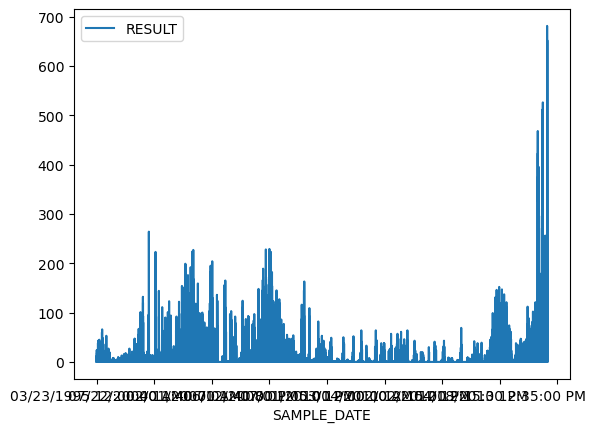

In [12]:
data = pd.DataFrame(rawData)

data.drop(["MEDIUM", "QUALIFIER", "SAMPLE_ID", "SAMPLE_SITE_NO", "METHOD", "PROJECT", "QC_FLAG", "DATA_REF_NO", "QC_TYPE", "TIME_NULL", "FILTER"], axis=1, inplace=True)

data[data["PARAM_TYPE"] == "Salamanders"].plot(x="SAMPLE_DATE", y="RESULT")

#Formatted date column

data["SAMPLE_DATE"] = data["SAMPLE_DATE"].map(lambda x: x.split(" ")[0])

data.groupby(["SAMPLE_DATE", "SITE_NAME", "PARAM_TYPE"], dropna=False).mean().head(1000)

#data.head(1000)

In [10]:
# condition mask
#mask = rawData['PARAM_TYPE'] == 'Salamanders'
 
# new dataframe with selected rows
#df_new = pd.DataFrame(rawData[mask])

# number of sample dataframes collected
count = 0 

for index, row in pd.DataFrame(rawData[rawData['PARAM_TYPE'] == 'Salamanders']).groupby(["SAMPLE_REF_NO"], dropna=False).mean().iterrows():
    mask = rawData["SAMPLE_REF_NO"] == index
    sampleDF = pd.DataFrame(rawData[mask]) # Dataframe containing all features relating so a single sample
    # TODO: Extract available features i.e. for feature in parameters:
    #                                           row with sampleDF[PARAM_TYPE] == feature
    #                                           add(row[Result]) to sampleSeries[feature.index]
    #                                       add(sampleSeries) to samplesDataFrame
    #   
    for feature in parameters:
        getParameter(sampleDF, feature)

    count+=1

print(count, " sample data frames seen")


NameError: name 'getParameter' is not defined

In [14]:
# df = pd.DataFrame(columns= parameters)

# for sample in samples:
#     #aggregating data for each sample
#     sampleData = dict()
#     for param in parameters:
#       sampleData.update({param : None})
#     sampleData.update({ID_FEATURE: sample})
#     sampleDF = rawData[rawData[ID_FEATURE] == sample]
#     #print(type(sampleDF))
#     for index, row in sampleDF.iterrows():
#         sampleData.update({row["PARAM_TYPE"]: row["RESULT"]})
#         print(row["PARAM_TYPE"], row["RESULT"])
#     print(sampleData)
#     #print(sampleData)
#     df.append(sampleData, ignore_index=True)   
# df.head()

### - not a useful codeblock i dont think, prefer above - ###

Oxygen 64.0
Oxygen 6.3
Oxygen 9.0
Oxygen 10.0
Oxygen 6.5
Oxygen 6.6
Oxygen 6.8
Oxygen 6.4
Oxygen 7.0
Oxygen 7.0
Oxygen 6.8
Oxygen 7.5
Oxygen 7.3
Oxygen 8.6
Oxygen 1.0
Oxygen 7.2
Oxygen 7.6
Oxygen 6.8
Oxygen 7.2
Oxygen 7.2
Oxygen 7.2
Oxygen 6.8
Oxygen 7.4
Oxygen 7.3
Oxygen 7.4
Oxygen 7.0
Oxygen 7.2
Oxygen 6.2
Oxygen 6.8
Oxygen 7.0
Oxygen 6.1
Oxygen 7.3
Oxygen 6.8
Oxygen 7.3
Oxygen 6.2
Oxygen 6.2
Oxygen 6.3
Oxygen 6.0
Oxygen 6.0
Oxygen 5.6
Oxygen 6.2
Oxygen 5.6
Oxygen 5.4
Oxygen 6.4
Oxygen 6.3
Oxygen 6.6
Oxygen 6.4
Oxygen 6.0
Oxygen 6.6
Oxygen 5.7
Oxygen 6.6
Oxygen 6.8
Oxygen 7.0
Oxygen 6.3
Oxygen 6.4
Oxygen 6.35
Oxygen 6.1
Oxygen 6.05
Oxygen 6.0
Oxygen 5.6
Oxygen 5.6
Oxygen 3.45
Oxygen 5.78
Oxygen 6.24
Oxygen 5.97
Oxygen 6.1
Oxygen 5.95
Oxygen 6.22
Oxygen 5.32
Oxygen 5.41
Oxygen 5.41
Oxygen 5.41
Oxygen 5.2
Oxygen 5.06
Oxygen 4.86
Oxygen 5.52
Oxygen 4.31
Salamanders 18.0
Salamanders 16.0
Salamanders 0.0
Oxygen 4.47
Oxygen 5.01
Salamanders 8.0
Salamanders 11.0
Salamanders 0.0
Oxygen 3.61


,Sample Number,Oxygen,Salamanders,Flow/Rainfall,Temporal,Physicals,Spatial,SITE_NAME,DATE
